In [2]:
import numpy as np
from scipy.spatial import cKDTree
import networkx as nx
import numpy as np
import matplotlib.pyplot as plt

In [63]:
def bresenham_line(x0, y0, x1, y1):
    """Yield integer coordinates on the line from (x0, y0) to (x1, y1) using Bresenham's algorithm."""
    x0, y0, x1, y1 = int(round(x0)), int(round(y0)), int(round(x1)), int(round(y1))
    dx = abs(x1 - x0)
    dy = abs(y1 - y0)
    x, y = x0, y0
    sx = 1 if x0 < x1 else -1
    sy = 1 if y0 < y1 else -1
    if dx > dy:
        err = dx / 2.0
        while x != x1:
            yield x, y
            err -= dy
            if err < 0:
                y += sy
                err += dx
            x += sx
        yield x, y
    else:
        err = dy / 2.0
        while y != y1:
            yield x, y
            err -= dx
            if err < 0:
                x += sx
                err += dy
            y += sy
        yield x, y

def prune_edges_by_map(edges, all_points, map_with_stations, max_water_crossings=2):
    pruned_edges = []
    for i, j in edges:
        x0, y0 = all_points[i]
        x1, y1 = all_points[j]
        # Sample the line between the two points
        line_pixels = list(bresenham_line(x0, y0, x1, y1))
        # Count how many pixels cross water (0)
        water_crossings = sum(
            map_with_stations[int(x), int(y)] == 0
            for x, y in line_pixels
            if 0 <= int(x) < map_with_stations.shape[0] and 0 <= int(y) < map_with_stations.shape[1]
        )
        if water_crossings <= max_water_crossings:
            pruned_edges.append((i, j))
    return np.array(pruned_edges)

In [64]:
# Create a random map with stations and water which is a river going through the map
def create_random_map_with_stations(map_size, num_nodes):
    # add a seed
    np.random.seed(3)
    map_with_stations = np.ones(map_size, dtype=int)  # Initialize with land (1)
    # Create a river (0) going through the map
    river_start = np.random.randint(0, map_size[0]), np.random.randint(0, map_size[1])
    river_end = np.random.randint(0, map_size[0]), np.random.randint(0, map_size[1])
    for x, y in bresenham_line(river_start[0], river_start[1], river_end[0], river_end[1]):
        if 0 <= x < map_size[0] and 0 <= y < map_size[1]:
            map_with_stations[x:x+4, y:y+4] = 0
    # Add stations (2) at random locations
    for _ in range(num_nodes):
        x, y = np.random.randint(0, map_size[0]), np.random.randint(0, map_size[1])
        if map_with_stations[x, y] == 1:
            map_with_stations[x, y] = 2
    return map_with_stations

def connect_stations_p_nn(map_with_stations, p):
    """Connect stations with its p nearest neighbours in the graph."""
    # Find all station coordinates
    station_coords = np.argwhere(map_with_stations == 2)
    num_stations = len(station_coords)
    if num_stations == 0:
        raise ValueError("No stations found in the map.")
    # Swap to (col, row) for plotting and KDTree
    station_coords_xy = np.array([(row, col) for row, col in station_coords])
    # Create a graph
    G = nx.Graph()
    pos = {}
    for i, (x, y) in enumerate(station_coords_xy):
        G.add_node(i)
        pos[i] = (x, y)
        # Create a KDTree for fast nearest neighbour search
    tree = cKDTree(station_coords_xy)
    for i in range(num_stations):
        # Query the p nearest neighbours
        distances, indices = tree.query(station_coords_xy[i], k=p + 1)  # +1 to exclude the point itself
        for j in indices[1:]:  # Skip the first one as it's the point itself
            G.add_edge(i, j)
    # Return the graph and positions
    return G, pos

# Make the graph and map
num_nodes = 300
num_edges = 40
map_size = (100, 100)
map_with_stations = create_random_map_with_stations(map_size, num_nodes)
G, pos = connect_stations_p_nn(map_with_stations, p=10)
# Get the edges and their positions
edges = np.array(list(G.edges()))
# Prune the edges based on water crossings
pruned_edges = prune_edges_by_map(edges, pos, map_with_stations)
# Create a new graph with pruned edges
pruned_graph = nx.Graph()
for i, j in pruned_edges:
    pruned_graph.add_edge(i, j)

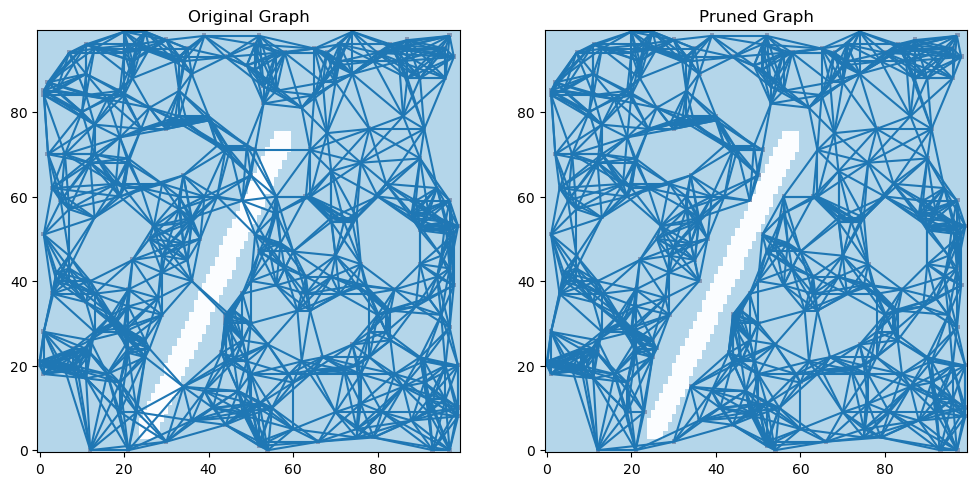

In [65]:
from matplotlib.collections import LineCollection

# Visualize the original and pruned graphs with the map in the background
def plot_graphs(G, pos, pruned_graph, map_with_stations):
    positions = np.array([(pos[i][0], pos[i][1]) for i in range(len(pos))])  # (x, y)
    edges = np.array(list(G.edges()))
    pruned_edges = np.array(list(pruned_graph.edges()))
    fig, axs = plt.subplots(1, 2, figsize=(12, 6))
    axes = axs.flatten()
    axes[0].set_title('Original Graph')
    axes[0].imshow(map_with_stations.T, origin='lower', cmap='Blues', alpha=0.5)
    # Prepare edge segments for LineCollection
    edge_segments = np.stack([
        np.stack([positions[edges[:, 0]], positions[edges[:, 1]]], axis=1)
    ], axis=0).reshape(-1, 2, 2)

    # Draw all edges at once
    lc = LineCollection(edge_segments)
    axes[0].add_collection(lc)

    axes[1].set_title('Pruned Graph')
    axes[1].imshow(map_with_stations.T, origin='lower', cmap='Blues', alpha=0.5)
    # Prepare edge segments for LineCollection
    pruned_edge_segments = np.stack([
        np.stack([positions[pruned_edges[:, 0]], positions[pruned_edges[:, 1]]], axis=1)
    ], axis=0).reshape(-1, 2, 2)
    # Draw pruned edges at once
    pruned_lc = LineCollection(pruned_edge_segments)
    axes[1].add_collection(pruned_lc)

plot_graphs(G, pos, pruned_graph, map_with_stations)